# Sequential Data


In this project, we will build a recurrent neural network to classify a SMS text message as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

## PART A - Spam Detection

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

### 1. Data Cleaning

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [11]:
import numpy as np
import pandas as pd

In [12]:
ham = []
spam = []
ham_count = 0
spam_count = 1
txt_df = pd.DataFrame(columns = ['Text', 'Non_Spam', 'Spam'])

for line in open('SMSSpamCollection'):
  split = line.split(None, 1)
  if split[0] == 'ham':
    txt_df = txt_df.append({'Text': split[1], 'Non_Spam': 1, 'Spam': 0}, ignore_index = True)
  if split[0] == 'spam':
    txt_df = txt_df.append({'Text': split[1], 'Non_Spam': 0, 'Spam': 1}, ignore_index = True)

In [13]:
print('The number of non-spam messages are:',txt_df.Non_Spam.value_counts()[1])
print('The number of spam messages are:',txt_df.Spam.value_counts()[1])


The number of non-spam messages are: 4827
The number of spam messages are: 747


In [145]:
import torchtext
from torchtext.legacy import data


text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                         "tsv",               # fields are separated by a tab
                         fields)



dataset[0].sms
dataset[0].label
train, valid, test = dataset.split(split_ratio = [0.6,0.2,0.2])

In [146]:
text_field.build_vocab(train[0].sms)
print('stoi:', text_field.vocab.stoi)
print('itos:', text_field.vocab.itos)

stoi: defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7efa56610210>>, {'<unk>': 0, '<pad>': 1, ' ': 2, '.': 3, 'e': 4, 'i': 5, 'r': 6, 't': 7, 's': 8, 'A': 9, 'h': 10, 'l': 11, 'o': 12, 'w': 13, 'N': 14, 'O': 15, 'g': 16, 'n': 17, '"': 18, ':': 19, 'C': 20, 'D': 21, 'E': 22, 'G': 23, 'I': 24, 'a': 25, 'b': 26, 'u': 27, '&': 28, ')': 29, ';': 30, 'B': 31, 'F': 32, 'H': 33, 'M': 34, 'R': 35, 'T': 36, 'V': 37, 'Y': 38, 'd': 39, 'f': 40, 'm': 41, 'p': 42, 'z': 43})
itos: ['<unk>', '<pad>', ' ', '.', 'e', 'i', 'r', 't', 's', 'A', 'h', 'l', 'o', 'w', 'N', 'O', 'g', 'n', '"', ':', 'C', 'D', 'E', 'G', 'I', 'a', 'b', 'u', '&', ')', ';', 'B', 'F', 'H', 'M', 'R', 'T', 'V', 'Y', 'd', 'f', 'm', 'p', 'z']


You saw that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

In [147]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

stoi - It is a method where token strings are converted or mapped to numerical identifiers.

itos – It is a list where token strings are indexed by their numerical identifiers.

In [148]:
text_field.build_vocab(train)
print('stoi:', text_field.vocab.stoi)
print('itos:', text_field.vocab.itos)

stoi: defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7efa5660f110>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, 'd': 14, '0': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'I': 34, 'C': 35, '4': 36, 'A': 37, 'O': 38, '7': 39, '6': 40, 'N': 41, 'x': 42, '3': 43, '!': 44, 'R': 45, ',': 46, '9': 47, 'P': 48, 'W': 49, 'H': 50, 'U': 51, 'M': 52, 'L': 53, 'D': 54, 'F': 55, '?': 56, 'G': 57, 'B': 58, "'": 59, 'Y': 60, '/': 61, '£': 62, ':': 63, '&': 64, '-': 65, 'z': 66, 'X': 67, 'V': 68, '*': 69, 'j': 70, 'K': 71, ')': 72, 'J': 73, '+': 74, ';': 75, 'Q': 76, '"': 77, '(': 78, 'q': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'ü': 84, 'Z': 85, '$': 86, 'Ü': 87, '|': 88, '\x92': 89, '_': 90, '‘': 91, '[': 92, ']': 93, '<': 94, '%': 95, '\x93': 96, '“':

The tokens `<unk>` and `<pad>` were not in our SMS text messages.


UNK - "unknown token" - is used to replace the rare words that did not fit in your vocabulary. So your sentence My name is guotong1988 will be translated into My name is _unk_.

PAD - your GPU (or CPU at worst) processes your training data in batches and all the sequences in your batch should have the same length.  If the max length of your sequence is 8, your sentence My name is guotong1988 will be padded from either side to fit this length: My name is guotong1988 _pad_ _pad_ _pad_ _pad_.

In [149]:
from torchtext.legacy import data
train_iter = data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


test_iter = data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [150]:
i = 0
for batch in train_iter:
    if i <=10:
      print('The length of batch is:', len(batch))
      print('The length of each sentences in this batch is:\n',batch.sms[1])
      print('The maximum length among all sentences is', batch.sms[1].max().item())
      pad_total = (batch.sms[0]==1).sum().item()
      print('The total padding in the sentence is', pad_total)
      print('\n')
      i +=1
    else:
      break

The length of batch is: 32
The length of each sentences in this batch is:
 tensor([47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 47, 47, 47, 47, 47, 47, 46, 46, 46, 46, 46, 46, 46])
The maximum length among all sentences is 47
The total padding in the sentence is 7


The length of batch is: 32
The length of each sentences in this batch is:
 tensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 41, 41, 41])
The maximum length among all sentences is 43
The total padding in the sentence is 25


The length of batch is: 32
The length of each sentences in this batch is:
 tensor([68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66,
        66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 65])
The maximum length among all sentences is 68
The total padding in the sentence is 49


The length of batch is: 32
The length of each sentences in this batch is:
 tenso

### 2. Model Building

Building a recurrent neural network model, using an architecture of your choosing. 
Using the one-hot embedding of each character as input to your recurrent network.
Using one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

This option is also explored in this project. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [151]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, out_type = 1):
    super(GRU, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.out_type = out_type
    self.name = 'GRU_h_{}m_{}'.format(hidden_size, out_type)
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2)

  def forward(self, x):
    x = self.emb[x]
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)

    if self.out_type == 1:
      out = self.fc(out[:,-1,:])
      return out

    if self.out_type == 2:
      out = self.fc(torch.max(out, dim=1)[0])
      return out
      
    if self.out_type == 3:
      out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
      return out

### 3. Training

In [152]:
def get_accuracy(model, input, criterion):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    #Function to calculate accuracy of the classification model
    criterion = criterion
    correct = 0
    total = 0
    total_loss = 0
    i = 0

    for each in input:

        output = model(each.sms[0])
        pred = output.max(1, keepdim=True)[1]

        correct += pred.eq(each.label.view_as(pred)).sum().item()
        total += each.label.shape[0]

        loss = criterion(output, each.label)
        total_loss += loss.item()
        i+=1
      
    loss = float(total_loss) / (i)
    acc = correct/total

    return loss, acc

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [153]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def train_gru_network(model, main_data, batch_size ,num_epochs=5, lr_rate=1e-5):
    
    #defining the train and validation iterator
    train_iter = main_data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

    val_iter = main_data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs 
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    tr_loss, val_loss, tr_acc, val_acc = [], [], [], []
    epochs = []
    print("--------------------Training Started------------------------------")
    start_time = time.time()
    for epoch in range(num_epochs):
        for each in train_iter:
            optimizer.zero_grad()
            pred = model(each.sms[0])
            loss = criterion(pred, each.label)
            loss.backward()
            optimizer.step()

        epochs.append(epoch)

        tr_each_l, tr_each_acc = get_accuracy(model, train_iter, criterion)

        with torch.no_grad(): 
          val_each_l, val_each_a = get_accuracy(model, val_iter, criterion)
        
        tr_loss.append(tr_each_l)
        val_loss.append(val_each_l)
        tr_acc.append(tr_each_acc)
        val_acc.append(val_each_a)

        print("Epoch %d; Train Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, tr_loss[epoch], val_loss[epoch], tr_acc[epoch], val_acc[epoch]))
        
        model_path = get_model_name(model.name, batch_size, lr_rate, epoch)
        torch.save(model.state_dict(), model_path)
    
    print('--------------------Training Completed----------------------------')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # plotting
    plt.title("Training and Validation Loss Curve")
    plt.plot(tr_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training and Validation Accuracy Curve")
    plt.plot(epochs, tr_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Validation Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Hyperparameters:

1. Model type: 3 different model types are used as suggested in part 2 starting.
2. Learning rate: 2e-4 or 1e-4
3. Hidden Size: 50, 100, 30
4. Batch size: 16 or 32

The best model performing model is batch size = 16, learning rate = 1e-4, hidden size = 30 and output type (max pool on the output array) and achieved the accuracy around 0.97 for validation set. I used this hyperparameter as they impact the model training directly.

--------------------Training Started------------------------------
Epoch 1; Train Loss 0.655100; Val Loss 0.706613; Train Acc 0.524764; Val Acc 0.132735
Epoch 2; Train Loss 0.335283; Val Loss 0.521508; Train Acc 0.943515; Val Acc 0.946188
Epoch 3; Train Loss 0.237649; Val Loss 0.234792; Train Acc 0.927282; Val Acc 0.979372
Epoch 4; Train Loss 0.196380; Val Loss 0.261418; Train Acc 0.947822; Val Acc 0.972197
Epoch 5; Train Loss 0.165051; Val Loss 0.151661; Train Acc 0.948816; Val Acc 0.977578
Epoch 6; Train Loss 0.157114; Val Loss 0.145202; Train Acc 0.949147; Val Acc 0.976682
Epoch 7; Train Loss 0.136029; Val Loss 0.137840; Train Acc 0.958754; Val Acc 0.975785
Epoch 8; Train Loss 0.409236; Val Loss 0.752917; Train Acc 0.890509; Val Acc 0.799103
Epoch 9; Train Loss 0.129915; Val Loss 0.149716; Train Acc 0.959086; Val Acc 0.972197
Epoch 10; Train Loss 0.123523; Val Loss 0.097679; Train Acc 0.960576; Val Acc 0.980269
Epoch 11; Train Loss 0.113812; Val Loss 0.096658; Train Acc 0.964055; Va

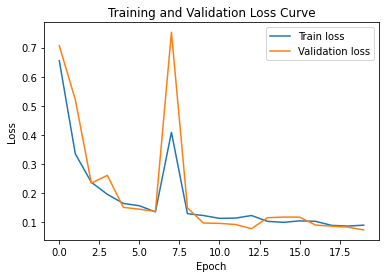

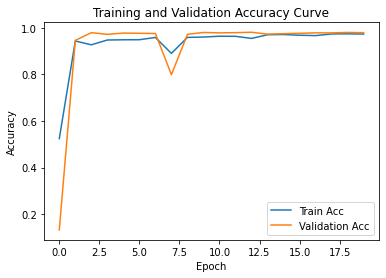

In [68]:
input_size = len(text_field.vocab)
model1 = GRU(input_size, 100, out_type = 2)
train_gru_network(model1, data, num_epochs=20, batch_size = 32, lr_rate=2e-4)

--------------------Training Started------------------------------
Epoch 1; Train Loss 4.452066; Val Loss 4.458595; Train Acc 0.520623; Val Acc 0.127354
Epoch 2; Train Loss 4.189445; Val Loss 4.194822; Train Acc 0.540335; Val Acc 0.184753
Epoch 3; Train Loss 4.060266; Val Loss 4.067160; Train Acc 0.505383; Val Acc 0.437668
Epoch 4; Train Loss 3.990210; Val Loss 3.996134; Train Acc 0.530396; Val Acc 0.571300
Epoch 5; Train Loss 3.961318; Val Loss 3.966043; Train Acc 0.482193; Val Acc 0.470852
Epoch 6; Train Loss 3.945348; Val Loss 3.949024; Train Acc 0.454033; Val Acc 0.453812
Epoch 7; Train Loss 3.931910; Val Loss 3.934873; Train Acc 0.451383; Val Acc 0.521076
Epoch 8; Train Loss 3.919438; Val Loss 3.921851; Train Acc 0.504224; Val Acc 0.556054
Epoch 9; Train Loss 3.906668; Val Loss 3.908673; Train Acc 0.479377; Val Acc 0.369507
Epoch 10; Train Loss 3.893697; Val Loss 3.895262; Train Acc 0.489813; Val Acc 0.476233
Epoch 11; Train Loss 3.880246; Val Loss 3.881446; Train Acc 0.511347; Va

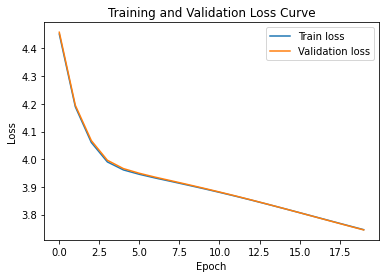

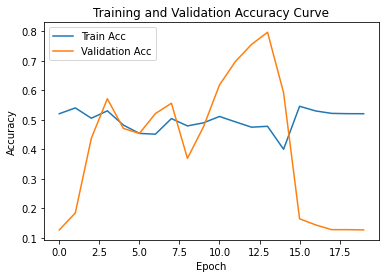

In [69]:
input_size = len(text_field.vocab)
model2 = GRU(input_size, 100, out_type = 3)
train_gru_network(model2, data, num_epochs=20, batch_size = 32, lr_rate=1e-4)

--------------------Training Started------------------------------
Epoch 1; Train Loss 0.680573; Val Loss 0.705572; Train Acc 0.518357; Val Acc 0.140807
Epoch 2; Train Loss 0.641746; Val Loss 0.685091; Train Acc 0.669908; Val Acc 0.416143
Epoch 3; Train Loss 0.467822; Val Loss 0.575786; Train Acc 0.943336; Val Acc 0.956951
Epoch 4; Train Loss 0.362316; Val Loss 0.449065; Train Acc 0.933445; Val Acc 0.973991
Epoch 5; Train Loss 0.305000; Val Loss 0.344674; Train Acc 0.931433; Val Acc 0.981166
Epoch 6; Train Loss 0.274304; Val Loss 0.275533; Train Acc 0.927745; Val Acc 0.981166
Epoch 7; Train Loss 0.236676; Val Loss 0.272864; Train Acc 0.952892; Val Acc 0.974888
Epoch 8; Train Loss 0.217668; Val Loss 0.231690; Train Acc 0.953395; Val Acc 0.978475
Epoch 9; Train Loss 0.200304; Val Loss 0.209271; Train Acc 0.956580; Val Acc 0.979372
Epoch 10; Train Loss 0.195312; Val Loss 0.187365; Train Acc 0.951048; Val Acc 0.980269
Epoch 11; Train Loss 0.220561; Val Loss 0.163052; Train Acc 0.926069; Va

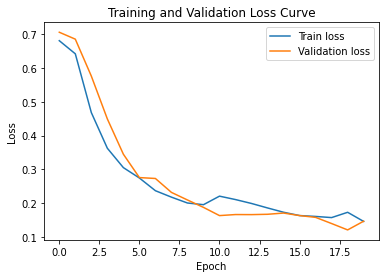

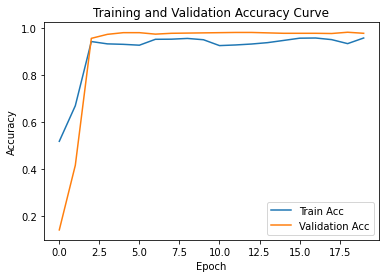

In [156]:
input_size = len(text_field.vocab)
model3 = GRU(input_size, 30, out_type = 2)
train_gru_network(model3, data, num_epochs=20, batch_size = 16, lr_rate=1e-4)

--------------------Training Started------------------------------
Epoch 1; Train Loss 0.688047; Val Loss 0.663381; Train Acc 0.476041; Val Acc 0.876233
Epoch 2; Train Loss 0.676325; Val Loss 0.674059; Train Acc 0.916186; Val Acc 0.937220
Epoch 3; Train Loss 0.659528; Val Loss 0.679875; Train Acc 0.849168; Val Acc 0.754260
Epoch 4; Train Loss 0.631750; Val Loss 0.669947; Train Acc 0.893134; Val Acc 0.822422
Epoch 5; Train Loss 0.564479; Val Loss 0.647612; Train Acc 0.924090; Val Acc 0.873543
Epoch 6; Train Loss 0.413856; Val Loss 0.590112; Train Acc 0.943191; Val Acc 0.922870
Epoch 7; Train Loss 0.362461; Val Loss 0.484855; Train Acc 0.932817; Val Acc 0.945291
Epoch 8; Train Loss 0.320801; Val Loss 0.455287; Train Acc 0.951095; Val Acc 0.943498
Epoch 9; Train Loss 0.295783; Val Loss 0.406012; Train Acc 0.942533; Val Acc 0.946188
Epoch 10; Train Loss 0.268938; Val Loss 0.385052; Train Acc 0.954224; Val Acc 0.945291
Epoch 11; Train Loss 0.252832; Val Loss 0.337474; Train Acc 0.946814; Va

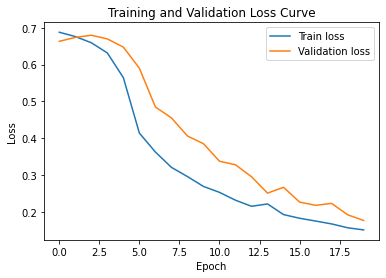

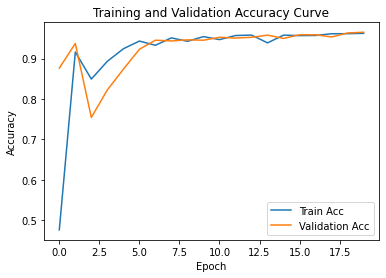

In [18]:
input_size = len(text_field.vocab)
model4 = GRU(input_size, 30, out_type = 2)
train_gru_network(model4, data, num_epochs=20, batch_size = 32, lr_rate=1e-4)

In [157]:
input_size = len(text_field.vocab)
hidden_size = 30
output_type = 2
net = GRU(input_size, hidden_size, output_type)
model_path = get_model_name(net.name, batch_size=16, learning_rate=1e-4, epoch=18)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [158]:
# Create a Dataset of only spam validation examples
valid_spam = data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

val_spam_iter = data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_nospam_iter = data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

criterion = nn.CrossEntropyLoss()
loss_spam, acc_spam = get_accuracy(net, val_spam_iter, criterion)
loss_nospam, acc_nospam = get_accuracy(net, val_nospam_iter, criterion)

In [159]:
print('False negative rate for validation set on best GRU:',1-acc_spam)
print('False positive rate for validation set on best GRU:',1-acc_nospam)

False negative rate for validation set on best GRU: 0.096551724137931
False positive rate for validation set on best GRU: 0.005154639175257714


- The impact of False Positive vs False Negative will impact the user as for example in case user recieves a spam message but is classified as non spam by our model then user might click some wrong link and could be in trouble.
- While, in case if the message is non spam but our model classifies as spam then the user would never know that message or might never receive that message in the inbox. Thus, both are equally important from a user's perspective.

### 4. Evaluation

In [160]:
test_loss, test_acc = get_accuracy(net, test_iter, criterion)
print('Test Accuracy for best GRU model:',test_acc)

Test Accuracy for best GRU model: 0.9685816876122083


In [161]:
# Create a Dataset of only spam test examples
tt_spam = data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

# Create a Dataset of only non-spam test examples
tt_nospam = data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

tt_spam_iter = data.BucketIterator(tt_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

tt_nospam_iter = data.BucketIterator(tt_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

tt_l_s, tt_acc_s = get_accuracy(net, tt_spam_iter, criterion)
tt_l_ns, tt_acc_ns = get_accuracy(net, tt_nospam_iter, criterion)

In [162]:
print('False negative rate for test set on best GRU:',1-tt_acc_s)
print('False positive rate for test set on best GRU:',1-tt_acc_ns)

False negative rate for test set on best GRU: 0.1333333333333333
False positive rate for test set on best GRU: 0.013698630136986356


0 = non-spam

1 = spam

In [163]:
msg = "machine learning is sooo cool!"
tokens = []

for i in msg:
  tokens.append(torch.tensor(text_field.vocab.stoi[i]))

tokens = torch.LongTensor(tokens).unsqueeze(dim= 0)
print(tokens.shape)

torch.Size([1, 30])


In [164]:
output = net(tokens)
pred = output.max(1, keepdim=True)[1]
print('Model predction of message:',int(pred))


Model predction of message: 0


In [165]:
import torch.nn.functional as F

prob = F.softmax(output, dim=1)
print('Probability prediction for the message as a spam message is:',float(prob[0][1]))

Probability prediction for the message as a spam message is: 0.100496307015419


**Previous Likeness Based Spam Filtering Technique**: This approach uses memory-based, or instance-based, machine learning methods to classify incoming emails based to their resemblance to stored examples (e.g. training emails). The attributes of the email are used to create a multi-dimensional space vector, which is used to plot new instances as points. The new instances are afterward allocated to the most popular class of its K-closest training instances. This approach uses the k-nearest neighbor (kNN) for filtering spam emails.

Additionally, other models like Naive Bayes, Simple Neural Network or Support Vector Machine models also can be used for spam detection.

## PART B - Transfer Learning

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [187]:
# install relevant libraries
!pip install fastai

In [189]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [190]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-03-23 19:28:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.5’

smsspamcollection.z 100%[===================>] 198.65K   957KB/s    in 0.2s    

2022-03-23 19:28:22 (957 KB/s) - ‘smsspamcollection.zip.5’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [191]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [192]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [193]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_temp = train_test_split(df1, stratify = df1['target'], test_size = 0.4, random_state = 0)
df_tt, df_val = train_test_split(df_temp, stratify = df_temp['target'], test_size = 0.5, random_state = 0)

In [194]:
df_trn.shape, df_val.shape, df_tt.shape

((3343, 2), (1115, 2), (1114, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [195]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, test_df = df_tt, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [196]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when three people get hit each year , but as a
The problem usually starts when a person is on a car or with other persons
The problem usually starts when players win a player . These players are often
The problem usually starts when Jane Blake has been living to prepare for
The problem usually starts when a player is killed in the running or as the


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [197]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.528905,4.560029,0.214286,00:05
1,4.839171,3.926204,0.257143,00:05
2,4.398044,3.759101,0.242857,00:05
3,4.080174,3.749260,0.242857,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.575514,3.702281,0.257143,00:05
1,3.541660,3.689012,0.228571,00:05
2,3.489264,3.670880,0.271429,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.388561,3.648182,0.242857,00:05
1,3.380728,3.622789,0.242857,00:05
2,3.363908,3.617648,0.257143,00:05


epoch,train_loss,valid_loss,accuracy,time
0,3.320828,3.599648,0.257143,00:06
1,3.287883,3.561395,0.242857,00:06
2,3.259069,3.561014,0.257143,00:06


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [198]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, test_df = df_tt, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [199]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
xxbos xxmaj for me the love should start with xxunk should feel that i need her every time around xxunk should be the first thing which comes in my thoughts . i would start the day and end it with xxunk should be there every time i xxunk will be then when my every breath has her xxunk life should happen around xxunk life will be named to her .,ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good boyfriend < #,ham
"xxbos a xxmaj boy loved a gal . xxmaj he propsd bt she did nt mind . xxmaj he gv lv lttrs , xxmaj bt her frnds threw thm . xxmaj again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal . xxmaj wn it was about 2 hit d girl , d boy ran like hell n saved her . xxmaj",ham
"xxbos xxmaj xxunk msg : xxmaj wen u lift d xxunk , u say "" xxup hello "" xxmaj do u knw xxunk is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" xxmaj xxunk xxmaj hello "" xxmaj she is",ham


In [200]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [237]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3343 items)
x: TextList
xxbos xxmaj every xxmaj king xxmaj was xxmaj once a xxmaj xxunk xxmaj baby xxmaj and xxmaj every xxmaj great xxmaj building xxmaj was xxmaj once a xxmaj xxunk .. xxmaj not xxmaj xxunk xxmaj where u r xxup today , xxup but xxmaj where u xxmaj wil xxmaj reach xxup xxunk . xxmaj gud ni8,xxbos xxmaj can you plz tell me the ans . xxup bslvyl sent via fullonsms.com,xxbos xxmaj as a valued customer , i am pleased to advise you that following recent review of your xxmaj mob xxmaj no . you are awarded with a £ 1500 xxmaj bonus xxmaj prize , call xxunk,xxbos xxunk : xxmaj to use your credit , click the xxup wap link in the next txt message or click here > > http : / / wap . xxunk,xxbos xxmaj is xy going 4 e lunch ?
y: CategoryList
ham,ham,spam,spam,ham
Path: .;

Valid: LabelList (1115 items)
x: TextList
xxbos xxmaj hi , can i please get a < # > xxunk loan from you . xxmaj i.ll pay you back by mid xxunk . xxmaj pls .,xx

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 2.09E-02


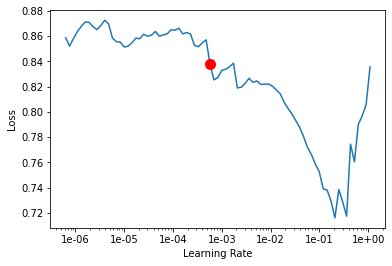

In [202]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [203]:
learn_classifier.fit_one_cycle(5, max_lr=1e-0, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.685187,0.401108,0.896861,00:06
1,10.692807,4.279727,0.865471,00:06
2,2.972250,0.106031,0.970404,00:07
3,0.583608,0.084325,0.968610,00:07
4,0.249046,0.119580,0.959641,00:07


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

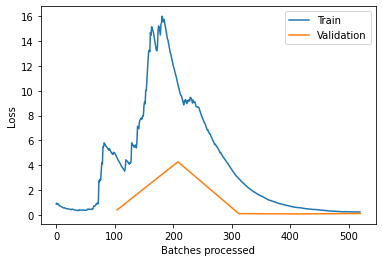

In [204]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


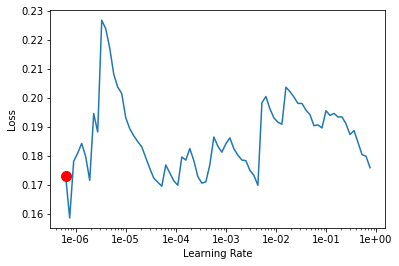

In [205]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [206]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9983e-01, 1.7422e-04]))

In [207]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(0), tensor(0), tensor([0.5290, 0.4710]))

Next we will evaluate on all of our validation data.

In [208]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1115, 2])

### 1. Evaluate Performance

The current accuracy for ULMFit is 0.76 which is not good as compared to GRU model and I think it might be due to that features of transfer learning learning might not be closely relavent to the dataset we have.

In [209]:
# get predictions from test set for ULMFiT
test_preds, test_label=learn_classifier.get_preds(ds_type=DatasetType.Test, ordered=True)
test_preds.shape

torch.Size([1114, 2])

In [211]:
df_tt.reset_index(inplace = True, drop = True)

In [217]:
i = 0
df_tt['label'] = np.nan
for i in range(0, df_tt.shape[0]):

  if df_tt.iloc[i].target == 'ham':
    df_tt.at[i, 'label'] = 0
  
  if df_tt.iloc[i].target == 'spam':
    df_tt.at[i, 'label'] = 1

In [218]:
true_ulmfit = [i for i in df_tt.label]
true_ulmfit = torch.tensor(true_ulmfit).unsqueeze(1)

In [219]:
correct, total = 0, 0
pred_ulmfit = test_preds.max(1, keepdim=True)[1]
correct += pred_ulmfit.eq(true_ulmfit.view_as(pred_ulmfit)).sum().item()
total += true_ulmfit.shape[0]

acc = correct/total
print('Test Accuracy for ULMFiT model:', acc)

Test Accuracy for ULMFiT model: 0.9640933572710951


In [220]:
correct = 0
total = 0
i = 0
GRU_pred = []
GRU_true = []

for char in test_iter:

    output = net(char.sms[0])
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(char.label.view_as(pred)).sum().item()
    total += char.label.shape[0]
    GRU_pred.extend(pred)
    GRU_true.extend(char.label)

acc = correct/total

print('Test Accuracy for best GRU model:',acc)

GRU_pred = torch.LongTensor(GRU_pred)
GRU_true = torch.LongTensor(GRU_true)

Test Accuracy for best GRU model: 0.9685816876122083


Both the confusion matrix plots for the ULMFit model and GRU model are plotted below. The main qualitative difference is the ULMFit model tends to fit the majority of misclassified under False-negative and for the GRU model it was producing more false positives than the ULMFit model.

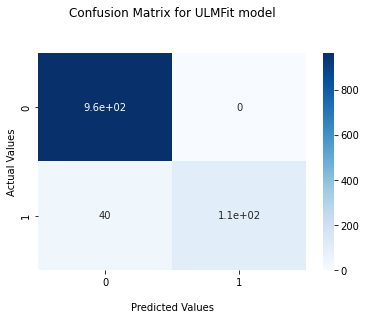

In [221]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_ulmfit = confusion_matrix(true_ulmfit, pred_ulmfit)
ax = sns.heatmap(cf_ulmfit, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for ULMFit model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
plt.show()


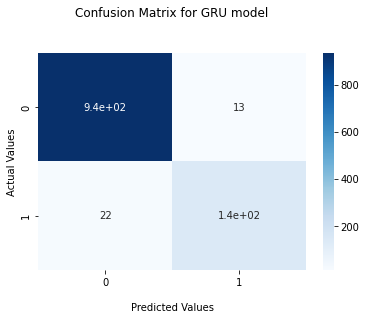

In [223]:
cf_rnn = confusion_matrix(GRU_true, GRU_pred)
ax = sns.heatmap(cf_rnn, annot=True, cmap="Blues")

ax.set_title('Confusion Matrix for GRU model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
plt.show()

### 2. Evaluate on New Data

- From the above matrix and accuracy, I would go with ULMFIT as my final model as it is giving my almost same accuracy in terms of classification but as we are using transfer learning it might perform better.
- After performing on real dataset, I can infer that neiter model performs better on the real message dataset and thus according to me more features like when it has arrived, from which mail ID or some grammatical mistake should be taken as features and then train the model again to improve the performance.

In [261]:
def p_new_ulmfit(sample):
  output = learn_classifier.predict(sample)[2]
  prob = F.softmax(output, dim = 0)
  print(prob[0])
  pred = output.numpy().argmax()
  catg = ''
  if pred == 1:
    catg = 'Spam'
  else:
    catg = 'Non-Spam'

  print('ULMFit Classification:',sample,' - ',catg)
  print('ULMFit Probability:',sample, ' - ', float(prob[0]))

In [255]:
def p_new_GRU(sample):
  
  tokens=[]
  for i in sample:
    tokens.append(torch.tensor(text_field.vocab.stoi[i]))

  tokens = torch.LongTensor([tokens])
  output = net(tokens)
  print(output)
  prob = F.softmax(output, dim=1)
  print(prob[0][1])
  pred = int(output.max(1, keepdim=True)[1])

  catg = ''
  if pred == 1:
    catg = 'Spam'
  else:
    catg = 'Non-Spam'

  print('GRU Classification:',sample,' - ',catg)
  print('GRU Probability:',sample, ' - ', float(prob[0][1]))


In [262]:
sample = "machine learning is sooo cool!"
p_new_ulmfit(sample)
print('-'*10)
sample = "Hurry now, click on the link for 10,000 USD"
p_new_ulmfit(sample)

tensor(0.7310)
ULMFit Classification: machine learning is sooo cool!  -  Non-Spam
ULMFit Probability: machine learning is sooo cool!  -  0.7310481667518616
----------
tensor(0.4911)
ULMFit Classification: Hurry now, click on the link for 10,000 USD  -  Spam
ULMFit Probability: Hurry now, click on the link for 10,000 USD  -  0.4910964071750641


From real world data, the GRU is performing good atleast on the sentence.

In [268]:
spam_ex = ['@6.4% = comforti home!',
               'Invitation to join Desh Videsh',
               'Holi Ready Sale',
               'Comes after END',
               'Financial update for go']

for i in spam_ex:
  p_new_ulmfit(i)
  p_new_GRU(i)
  print('-'*100)

tensor(0.7309)
ULMFit Classification: @6.4% = comforti home!  -  Non-Spam
ULMFit Probability: @6.4% = comforti home!  -  0.7308570742607117
tensor([[ 0.3156, -0.3611]], grad_fn=<AddmmBackward0>)
tensor(0.3370, grad_fn=<SelectBackward0>)
GRU Classification: @6.4% = comforti home!  -  Non-Spam
GRU Probability: @6.4% = comforti home!  -  0.33699992299079895
----------------------------------------------------------------------------------------------------
tensor(0.7301)
ULMFit Classification: Invitation to join Desh Videsh  -  Non-Spam
ULMFit Probability: Invitation to join Desh Videsh  -  0.7300558686256409
tensor([[ 1.3011, -1.3408]], grad_fn=<AddmmBackward0>)
tensor(0.0665, grad_fn=<SelectBackward0>)
GRU Classification: Invitation to join Desh Videsh  -  Non-Spam
GRU Probability: Invitation to join Desh Videsh  -  0.06648725271224976
----------------------------------------------------------------------------------------------------
tensor(0.7306)
ULMFit Classification: Holi Ready Sal

In [264]:
non_spam_ex = ['9 new things that you might not know: Exam Ready Edition',
           'Last chance to take part in the Canadian Graduate and Professional Student Survey',
           'Recent Canvas Notifications',
           'New Course: Parallel Programming with Dask in Python',
           'Group presentations on April 11']

for i in non_spam_ex:
  p_new_ulmfit(i)
  p_new_GRU(i)
  print('-'*100)

tensor(0.7258)
ULMFit Classification: 9 new things that you might not know: Exam Ready Edition  -  Non-Spam
ULMFit Probability: 9 new things that you might not know: Exam Ready Edition  -  0.7257978916168213
tensor([[ 0.6210, -0.6130]], grad_fn=<AddmmBackward0>)
tensor(0.2255, grad_fn=<SelectBackward0>)
GRU Classification: 9 new things that you might not know: Exam Ready Edition  -  Non-Spam
GRU Probability: 9 new things that you might not know: Exam Ready Edition  -  0.22548866271972656
----------------------------------------------------------------------------------------------------
tensor(0.7160)
ULMFit Classification: Last chance to take part in the Canadian Graduate and Professional Student Survey  -  Non-Spam
ULMFit Probability: Last chance to take part in the Canadian Graduate and Professional Student Survey  -  0.715973973274231
tensor([[ 1.0557, -1.0839]], grad_fn=<AddmmBackward0>)
tensor(0.1053, grad_fn=<SelectBackward0>)
GRU Classification: Last chance to take part in the 

References:

https://www.sciencedirect.com/science/article/pii/S2405844018353404